In [2]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import re
import string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

In [3]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [4]:
# Shape 
fake_df.shape, true_df.shape

((23481, 4), (21417, 4))

In [5]:
print(fake_df.columns == true_df.columns)

[ True  True  True  True]


In [6]:
fake_df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
# Check for duplicates in both the file

fake_df.drop_duplicates(inplace=True)
true_df.drop_duplicates(inplace=True)


# Count the missing values
print("Missing values in Fake news dataset:")
print(fake_df.isnull().sum())
print("\nMissing values in True news dataset:")
print(true_df.isnull().sum())

Missing values in Fake news dataset:
title      0
text       0
subject    0
date       0
dtype: int64

Missing values in True news dataset:
title      0
text       0
subject    0
date       0
dtype: int64


### Mergeing Two DF

In [9]:
# If both files have the same columns
true_df['label'] = 1
fake_df['label'] = 0

merged_data = pd.concat([true_df, fake_df], axis=0, ignore_index=True)

# Shuffle the dataset to mix real and fake news
merged_data = merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Merged dataset shape:", merged_data.shape)
print("\nLabel distribution:")
print(merged_data['label'].value_counts())

Merged dataset shape: (44689, 5)

Label distribution:
label
0    23478
1    21211
Name: count, dtype: int64


## Basic Text Cleaning

In [10]:
def basic_cleaning(text):
    """Step 1: Basic text cleaning"""
    if pd.isna(text):
        return ""
    
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 4. Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    return text

# Apply basic cleaning
merged_data['text'] = merged_data['text'].apply(basic_cleaning)
merged_data['title'] = merged_data['title'].apply(basic_cleaning)
merged_data['subject'] = merged_data['subject'].apply(basic_cleaning)

## Remove Special Characters & Numbers

In [11]:
def remove_special_chars_numbers(text):
    """Step 2: Remove special characters, punctuation, and numbers"""
    # 5. Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 6. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 7. Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply character cleaning
merged_data['text'] = merged_data['text'].apply(remove_special_chars_numbers)
merged_data['title'] = merged_data['title'].apply(remove_special_chars_numbers)
merged_data['subject'] = merged_data['subject'].apply(remove_special_chars_numbers)

## Tokenization

In [12]:
def tokenize_text(text):
    """Step 3: Tokenize text into words"""
    # Simple split tokenization
    words = text.split()
    return words

# Apply tokenization
merged_data['text'] = merged_data['text'].apply(tokenize_text)
merged_data['title'] = merged_data['title'].apply(tokenize_text)
merged_data['subject'] = merged_data['subject'].apply(tokenize_text)

In [13]:
def remove_stop_words(tokens):
    """Step 4: Remove stop words from tokens"""
    stop_words = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
        "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
        'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
        'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
        'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
        'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
        'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
        'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
        'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
        'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
        'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
        'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
        "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', 
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 
        'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
        'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    }
    
    filtered_words = [word for word in tokens if word not in stop_words]
    return filtered_words

# Apply stop words removal
merged_data['text'] = merged_data['text'].apply(remove_stop_words)
merged_data['title'] = merged_data['title'].apply(remove_stop_words)
merged_data['subject'] = merged_data['subject'].apply(remove_stop_words)

## Stemming

In [14]:
def apply_stemming(tokens):
    """Step 5: Apply stemming to tokens"""
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokens]
    return stemmed_words

# Apply stemming
merged_data['text'] = merged_data['text'].apply(apply_stemming)
merged_data['title'] = merged_data['title'].apply(apply_stemming)
merged_data['subject'] = merged_data['subject'].apply(apply_stemming)

## Final Text Reconstruction

In [15]:
def reconstruct_text(tokens):
    """Step 6: Convert tokens back to text"""
    return ' '.join(tokens)

# Reconstruct final cleaned text
merged_data['text'] = merged_data['text'].apply(reconstruct_text)
merged_data['title'] = merged_data['title'].apply(reconstruct_text)
merged_data['subject'] = merged_data['subject'].apply(reconstruct_text)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Option A: TF-IDF Vectorization (Recommended)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           # Keep top 5000 features
    ngram_range=(1, 2),          # Unigrams and bigrams
    min_df=2,                    # Ignore terms that appear in < 2 documents
    max_df=0.85,                 # Ignore terms that appear in > 85% documents
    stop_words='english'         # Additional stop word removal
)

# FIX: Combine multiple text columns into one
merged_data['combined_text'] = merged_data['text'] + " " + merged_data['title'] + " " + merged_data['subject']

# Use the combined text column
X = tfidf_vectorizer.fit_transform(merged_data['combined_text'])
y = merged_data['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Feature matrix shape: (44689, 5000)
Number of features: 5000


## Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,              # 80% training, 20% testing
    random_state=42,            # For reproducibility
    stratify=y                  # Maintain class distribution in splits
)

print("✅ Train-test split completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

✅ Train-test split completed!
Training set: 35751 samples
Test set: 8938 samples
Number of features: 5000


## Model Training

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Initialize multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000)  # Fixed: Using LinearSVC
}

# Train all models
print("Training models...")
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"✓ {name} trained")

print("✅ All models trained successfully!")

Training models...
Training Logistic Regression...
✓ Logistic Regression trained
Training Random Forest...
✓ Random Forest trained
Training Naive Bayes...
✓ Naive Bayes trained
Training Linear SVM...
✓ Linear SVM trained
✅ All models trained successfully!


## Model Evaluation

MODEL EVALUATION:

📊 Logistic Regression Results:
Accuracy: 0.9934

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      4696
        Real       0.99      1.00      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



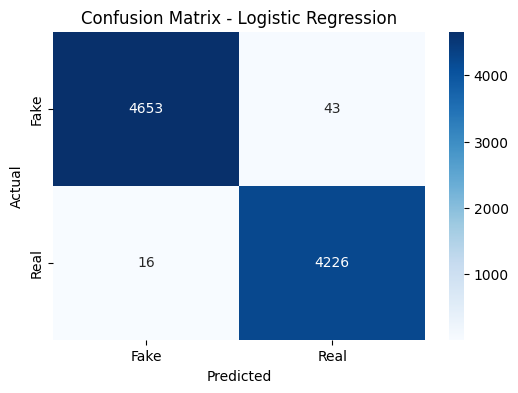


📊 Random Forest Results:
Accuracy: 0.9994

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4242

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



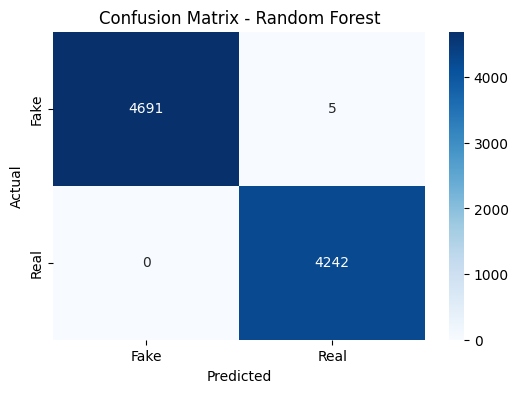


📊 Naive Bayes Results:
Accuracy: 0.9467

Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4696
        Real       0.94      0.95      0.94      4242

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



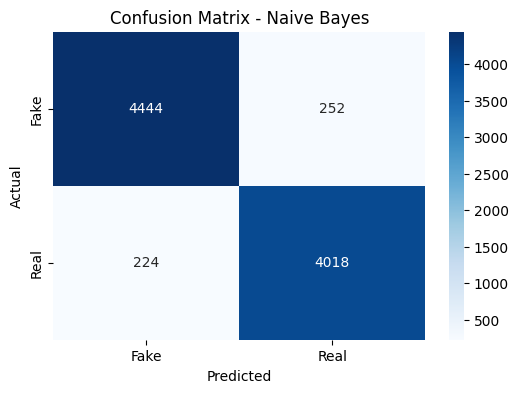


📊 Linear SVM Results:
Accuracy: 0.9977

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4242

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



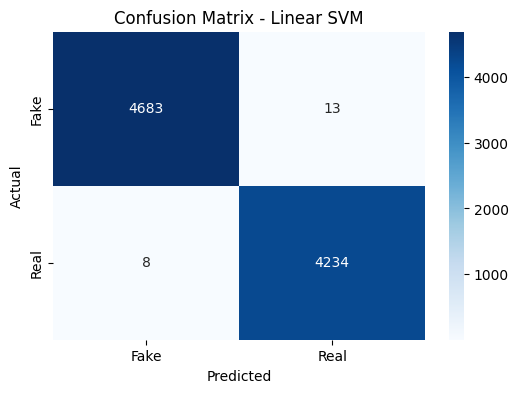


📈 MODEL COMPARISON SUMMARY:
Random Forest        0.9994
Linear SVM           0.9977
Logistic Regression  0.9934
Naive Bayes          0.9467


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a single model"""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'Real'], 
                yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy

# Evaluate all models
print("MODEL EVALUATION:")
print("=" * 50)
model_accuracies = {}

for name, model in trained_models.items():
    accuracy = evaluate_model(model, X_test, y_test, name)
    model_accuracies[name] = accuracy

print("\n" + "=" * 50)
print("📈 MODEL COMPARISON SUMMARY:")
print("=" * 50)
for name, accuracy in sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20} {accuracy:.4f}")

## Select Best Model

In [20]:
# Find the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_model = trained_models[best_model_name]

print(f"\n🎯 BEST MODEL: {best_model_name}")
print(f"Best Accuracy: {model_accuracies[best_model_name]:.4f}")

# Compare all models
print("\n📈 MODEL COMPARISON:")
for name, acc in sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20} {acc:.4f}")


🎯 BEST MODEL: Random Forest
Best Accuracy: 0.9994

📈 MODEL COMPARISON:
Random Forest        0.9994
Linear SVM           0.9977
Logistic Regression  0.9934
Naive Bayes          0.9467


## Hyperparameter Tuning

In [21]:
from sklearn.model_selection import GridSearchCV

# Tune the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
elif best_model_name == 'Linear SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'loss': ['hinge', 'squared_hinge'],
        'max_iter': [1000, 2000]
    }
elif best_model_name == 'Naive Bayes':
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }
else:
    param_grid = {}  # Skip tuning for other models

if param_grid:
    print(f"\n🔧 Tuning {best_model_name}...")
    grid_search = GridSearchCV(
        best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"✅ Best CV score: {grid_search.best_score_:.4f}")
    
    # Show improvement
    original_accuracy = model_accuracies[best_model_name]
    improvement = grid_search.best_score_ - original_accuracy
    print(f"📈 Improvement after tuning: {improvement:+.4f}")
else:
    print(f"\n⚠️  No hyperparameter tuning defined for {best_model_name}")
    print("Proceeding with default parameters...")


🔧 Tuning Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best CV score: 0.9992
📈 Improvement after tuning: -0.0003


## Final Model Evaluation


🎯 FINAL EVALUATION - Tuned Model
Accuracy: 0.9994

📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4242

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



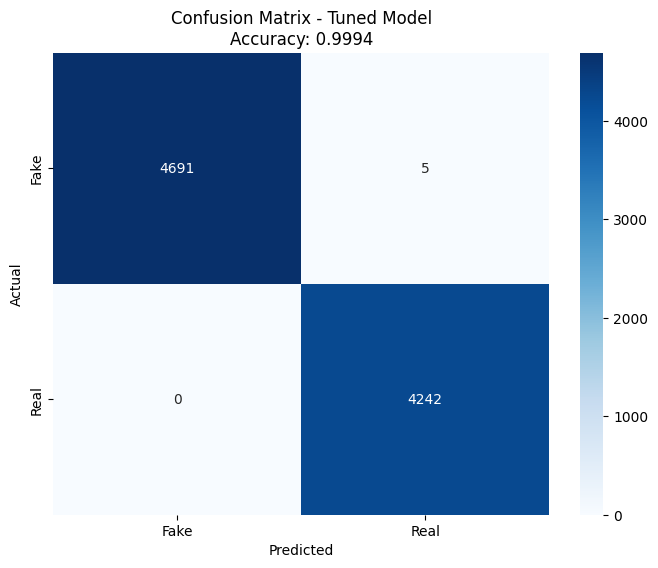

In [22]:
def detailed_evaluation(model, X_test, y_test, model_name):
    """Comprehensive evaluation with visualization"""
    y_pred = model.predict(X_test)
    
    # Check if model has predict_proba (LinearSVC doesn't)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n🎯 FINAL EVALUATION - {model_name}")
    print("=" * 60)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print("\n📋 Detailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'Real'], 
                yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.4f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy

# Final evaluation
final_accuracy = detailed_evaluation(best_model, X_test, y_test, "Tuned Model")